In [2]:
# Install pytorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install other libraries
!pip install opencv-python matplotlib pycocotools

Looking in indexes: https://download.pytorch.org/whl/cu118


In [3]:
# Install compatible Detectron2 version for current PyTorch
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vjdjka2v
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vjdjka2v
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.4 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6733316 sha256=9d3a167220a5901b1117aa8623fc96902967d04db72e2ff94ec675b54823f64b
  Stored in directory: /tmp/pip-ephem-wheel-cache-qha5kq3g/wheels/d3/6e/bd/1969578f1456a6be

In [ ]:
# !pip uninstall -y detectron2

In [4]:
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer

print("Detectron2 installed successfully!")

Detectron2 installed successfully!


In [5]:
# Download COCO 2017 train and val datasets
!mkdir -p coco_dataset

# Download val2017 images (~1GB)
!wget -q http://images.cocodataset.org/zips/val2017.zip -O coco_dataset/val2017.zip
!unzip -q coco_dataset/val2017.zip -d coco_dataset/

# Download train2017 images (~18GB)
!wget -q http://images.cocodataset.org/zips/train2017.zip -O coco_dataset/train2017.zip
!unzip -q coco_dataset/train2017.zip -d coco_dataset/

# Download annotations (~241MB)
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_dataset/annotations_trainval2017.zip
!unzip -q coco_dataset/annotations_trainval2017.zip -d coco_dataset/


In [7]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog

# Load Detectron2 config for panoptic segmentation
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for instance detection
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
cfg.MODEL.DEVICE = "cuda"  # or "cpu" if no GPU

# Create predictor
predictor = DefaultPredictor(cfg)

model_final_c10459.pkl: 184MB [00:00, 204MB/s]                           


In [6]:
import os
import cv2
import json
import numpy as np
from detectron2.utils.visualizer import Visualizer, ColorMode
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

In [8]:
# Load COCO annotations (val2017)
ann_file = "coco_dataset/annotations/instances_val2017.json"
coco = COCO(ann_file)

# If using Detectron2, also load metadata
from detectron2.data import MetadataCatalog
metadata = MetadataCatalog.get("coco_2017_val")  # Detectron2 metadata

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


In [1]:
sky_class_id = 40  # COCO category ID for sky

class CocoSkyProcessor:
    def __init__(self, coco, predictor, metadata, output_folder="coco_sky_removed"):
        self.coco = coco
        self.predictor = predictor
        self.metadata = metadata
        self.output_folder = output_folder
        self.cropped_folder = os.path.join(output_folder, "images", "cropped")
        self.no_sky_folder = os.path.join(output_folder, "images", "no_sky")
        self.annotation_folder = os.path.join(output_folder, "annotations")
        os.makedirs(self.cropped_folder, exist_ok=True)
        os.makedirs(self.no_sky_folder, exist_ok=True)
        os.makedirs(self.annotation_folder, exist_ok=True)

        self.new_annotations = {"images": [], "annotations": [], "categories": self.coco.dataset["categories"]}
        self.ann_id_counter = 1

    # ------------------------------
    # Sky removal & cropping
    # ------------------------------
    def remove_sky_from_image(self, img):
        outputs = self.predictor(img)["panoptic_seg"]
        panoptic_seg = outputs[0].cpu().numpy()
        segments_info = outputs[1]

        sky_mask = np.zeros_like(panoptic_seg, dtype=np.uint8)
        for seg in segments_info:
            if seg["category_id"] == sky_class_id:
                sky_mask[panoptic_seg == seg["id"]] = 255

        img_no_sky = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(sky_mask))
        return img_no_sky, sky_mask


    def crop_sky_from_image(self, img):
        """
        Crops out all rows that contain sky.
        Returns the cropped image and number of rows cropped from the top.
        """
        outputs = self.predictor(img)["panoptic_seg"]
        panoptic_seg = outputs[0].cpu().numpy()
        segments_info = outputs[1]

        sky_mask = np.zeros_like(panoptic_seg, dtype=np.uint8)
        for seg in segments_info:
            if seg["category_id"] == sky_class_id:
                sky_mask[panoptic_seg == seg["id"]] = 255

        sky_rows = np.any(sky_mask == 255, axis=1)
        if not np.any(sky_rows):
            return img, 0

        bottom_sky_row = np.max(np.where(sky_rows)[0])
        img_cropped = img[bottom_sky_row + 1:, :, :]
        return img_cropped, bottom_sky_row + 1

    # ------------------------------
    # Process single image
    # ------------------------------
    def process_image(self, img_id):
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join("coco_dataset/val2017", img_info["file_name"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Remove sky
        img_no_sky, sky_mask = self.remove_sky_from_image(img)

        # Crop image
        img_cropped, crop_offset = self.crop_sky_from_image(img)

        # Save images
        no_sky_path = os.path.join(self.no_sky_folder, img_info["file_name"])
        cropped_path = os.path.join(self.cropped_folder, img_info["file_name"])
        cv2.imwrite(no_sky_path, cv2.cvtColor(img_no_sky, cv2.COLOR_RGB2BGR))
        cv2.imwrite(cropped_path, cv2.cvtColor(img_cropped, cv2.COLOR_RGB2BGR))

        # Update annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        new_img_info = img_info.copy()
        new_img_info["height"] = img_cropped.shape[0]
        new_img_info["width"] = img_cropped.shape[1]
        self.new_annotations["images"].append(new_img_info)

        for ann in anns:
            mask = self.coco.annToMask(ann)
            # Crop mask
            mask_cropped = mask[crop_offset:, :]
            if mask_cropped.sum() == 0:
                continue
            new_ann = ann.copy()
            new_ann["segmentation"] = []  # optional, can use RLE conversion
            new_ann["image_id"] = img_id
            new_ann["id"] = self.ann_id_counter
            self.ann_id_counter += 1
            new_ann["bbox"] = [0,0,mask_cropped.shape[1], mask_cropped.shape[0]]  # approximate bbox
            self.new_annotations["annotations"].append(new_ann)

        return img, img_no_sky, img_cropped

    # ------------------------------
    # Sequential processing for large datasets (Colab-safe)
    # ------------------------------
    def process_dataset_sequential(self, img_ids, save_every=500):
        processed = []
        for idx, img_id in enumerate(tqdm(img_ids)):
            processed.append(self.process_image(img_id))

            # Save intermediate COCO JSON every `save_every` images
            if (idx + 1) % save_every == 0:
                self.save_new_coco_json(filename=f"instances_cropped_partial_{idx+1}.json")
        return processed

    # ------------------------------
    # Save COCO JSON
    # ------------------------------
    def save_new_coco_json(self, filename="instances_cropped.json"):
        save_path = os.path.join(self.annotations_folder, filename)
        with open(save_path, "w") as f:
            json.dump(self.new_dataset, f)
        print(f"Saved new COCO annotations to {save_path}")

        # output_path = os.path.join(self.annotation_folder, filename)
        # with open(output_path, "w") as f:
        #     json.dump(self.new_annotations, f)
        # print(f"Saved annotations to {output_path}")


    # ------------------------------
    # Visualization
    # ------------------------------
    # def visualize_processed_image_with_annotations(self, img_id):
    #     img_info = self.coco.loadImgs(img_id)[0]
    #     original_path = os.path.join("coco_dataset/val2017", img_info["file_name"])
    #     cropped_path = os.path.join(self.images_folder, f"{img_info['file_name'].split('.')[0]}.jpg")

    #     img_orig = cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB)
    #     img_cropped = cv2.cvtColor(cv2.imread(cropped_path), cv2.COLOR_BGR2RGB)
    #     img_no_sky, _, top_row = self.remove_and_crop_sky(img_orig)

    #     ann_ids = self.coco.getAnnIds(imgIds=img_id)
    #     anns = self.coco.loadAnns(ann_ids)
    #     dataset_id_to_contiguous_id = self.metadata.thing_dataset_id_to_contiguous_id

    #     masks_orig, labels_orig = [], []
    #     masks_cropped, labels_cropped = [], []

    #     for ann in anns:
    #         if ann["category_id"] in dataset_id_to_contiguous_id:
    #             mask = self.coco.annToMask(ann).astype(np.uint8)

    #             # Original + sky removed
    #             masks_orig.append(mask)
    #             labels_orig.append(self.metadata.thing_classes[dataset_id_to_contiguous_id[ann["category_id"]]])

    #             # Cropped
    #             mask_crop = mask[top_row:, :]
    #             if mask_crop.sum() > 0:
    #                 masks_cropped.append(mask_crop)
    #                 labels_cropped.append(self.metadata.thing_classes[dataset_id_to_contiguous_id[ann["category_id"]]])

    #     v_orig = Visualizer(img_orig, metadata=self.metadata, scale=1.0, instance_mode=ColorMode.IMAGE).overlay_instances(masks=masks_orig, labels=labels_orig)
    #     v_no_sky = Visualizer(img_no_sky, metadata=self.metadata, scale=1.0, instance_mode=ColorMode.IMAGE).overlay_instances(masks=masks_orig, labels=labels_orig)
    #     v_cropped = Visualizer(img_cropped, metadata=self.metadata, scale=1.0, instance_mode=ColorMode.IMAGE).overlay_instances(masks=masks_cropped, labels=labels_cropped)

    #     import matplotlib.pyplot as plt
    #     plt.figure(figsize=(18, 6))
    #     plt.subplot(1, 3, 1)
    #     plt.imshow(v_orig.get_image())
    #     plt.title("Original + Annotations")
    #     plt.axis("off")

    #     plt.subplot(1, 3, 2)
    #     plt.imshow(v_no_sky.get_image())
    #     plt.title("Sky Removed + Annotations")
    #     plt.axis("off")

    #     plt.subplot(1, 3, 3)
    #     plt.imshow(v_cropped.get_image())
    #     plt.title("Sky Cropped + Annotations")
    #     plt.axis("off")
    #     plt.show()

    def visualize_processed_image_with_annotations(self, img_id):
        img_orig, img_no_sky, img_cropped = self.process_image(img_id)

        # Visualize side by side
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))
        axes[0].imshow(img_orig)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(img_no_sky)
        axes[1].set_title("Sky Removed")
        axes[1].axis("off")

        axes[2].imshow(img_cropped)
        axes[2].set_title("Sky Cropped")
        axes[2].axis("off")

        plt.show()


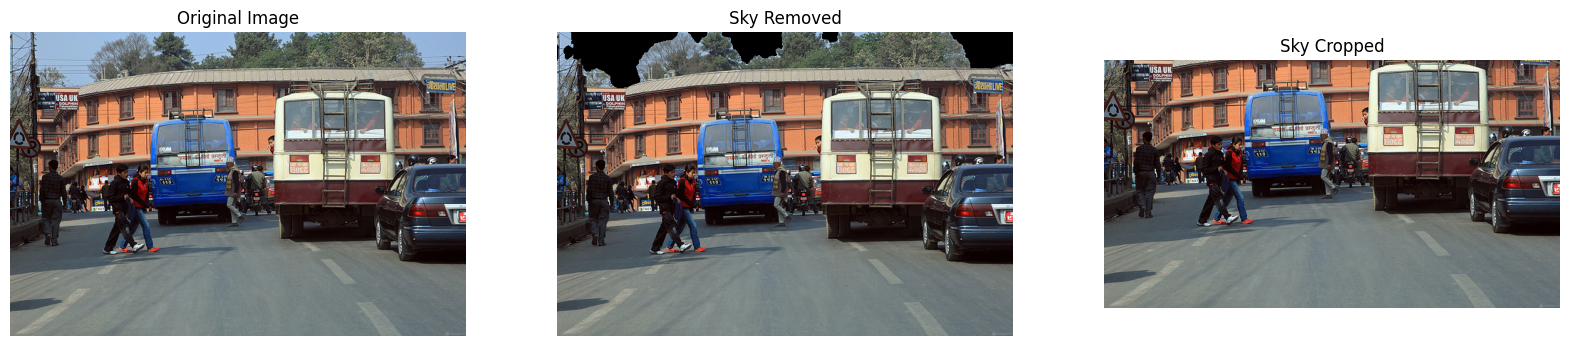

In [66]:
processor = CocoSkyProcessor(coco, predictor, metadata)

# Process first 50 images
sample_ids = coco.getImgIds()[:50]
processor.process_dataset_sequential(sample_ids)

# # Save new COCO annotations
processor.save_new_coco_json()

# Visualize one processed image
processor.visualize_processed_image_with_annotations(sample_ids[22])

In [69]:
processor = CocoSkyProcessor(coco, predictor, metadata)

# Process all 5000 images safely
all_ids = coco.getImgIds()
processor.process_image(all_ids, save_every=500)

# Save final COCO JSON
processor.save_new_coco_json("instances_cropped_full.json")

# Visualize any processed image
processor.visualize_processed_image_with_annotations(all_ids[500])

AttributeError: 'CocoSkyProcessor' object has no attribute 'save_new_coco_json'

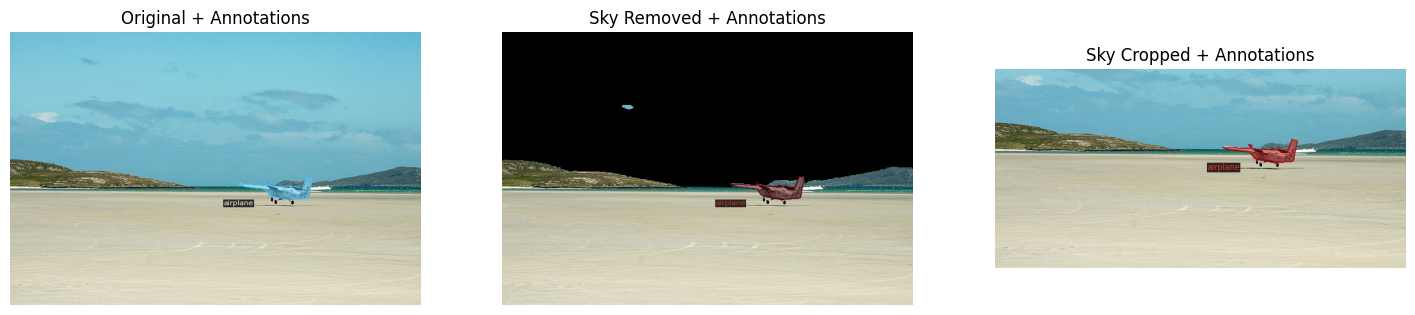

In [49]:
processor.visualize_processed_image_with_annotations(all_ids[500])

In [31]:
import shutil
from google.colab import files

# Path to the folder you want to zip
folder_to_zip = "coco_sky_removed"

# Name of the output zip file
zip_filename = "coco_sky_removed.zip"

# Zip the folder
shutil.make_archive(zip_filename.replace('.zip',''), 'zip', folder_to_zip)

# Download the zip file
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>